<a href="https://colab.research.google.com/github/moist234/ECON3916-Statistical-Machine-Learning/blob/main/Assignment-02/Econ_3916_Assignment_2_Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
np.random.seed(42)
normal_traffic = np.random.randint(20, 50, 980)      # 20..49 ms
spike_traffic  = np.random.randint(1000, 5000, 20)   # 1000..4999 ms
latency_logs   = np.concatenate([normal_traffic, spike_traffic])

def calculate_mad(data: np.ndarray):
    data = np.asarray(data)
    med = np.median(data)
    abs_dev = np.abs(data - med)
    mad = np.median(abs_dev)
    return float(mad)

mean_latency = float(np.mean(latency_logs))
median_latency = float(np.median(latency_logs))
sd_latency = float(np.std(latency_logs, ddof=1))
mad_latency = calculate_mad(latency_logs)

p95 = float(np.percentile(latency_logs, 95))
p99 = float(np.percentile(latency_logs, 99))
p999 = float(np.percentile(latency_logs, 99.9))
max_latency = int(np.max(latency_logs))

phase1 = {
    "n_requests": len(latency_logs),
    "mean_ms": mean_latency,
    "median_ms": median_latency,
    "sd_ms": sd_latency,
    "mad_ms": mad_latency,
    "p95_ms": p95,
    "p99_ms": p99,
    "p99.9_ms": p999,
    "max_ms": max_latency,
    "spike_count": int((latency_logs >= 1000).sum())
}

phase1

{'n_requests': 1000,
 'mean_ms': 95.911,
 'median_ms': 36.0,
 'sd_ms': 459.1214671528664,
 'mad_ms': 8.0,
 'p95_ms': 49.0,
 'p99_ms': 3007.2399999999934,
 'p99.9_ms': 4636.298000000027,
 'max_ms': 4934,
 'spike_count': 20}

In [35]:
def bayesian_audit(prior: float, sensitivity: float, specificity: float) -> float:
    prior = float(prior)
    sensitivity = float(sensitivity)
    specificity = float(specificity)
    num = sensitivity * prior
    den = num + (1.0 - specificity) * (1.0 - prior)
    return float(num / den)

sens = 0.98
spec = 0.98

scenarios = {
    "A Bootcamp (50%)": 0.50,
    "B Econ Class (5%)": 0.05,
    "C Honors Seminar (0.1%)": 0.001
}

posteriors = {name: bayesian_audit(pr, sens, spec) for name, pr in scenarios.items()}


posteriors


{'A Bootcamp (50%)': 0.98,
 'B Econ Class (5%)': 0.7205882352941175,
 'C Honors Seminar (0.1%)': 0.04675572519083965}

In [36]:
control = 50250
treatment = 49750
total = control + treatment

observed = np.array([control, treatment], dtype=float)
expected = np.array([total / 2.0, total / 2.0], dtype=float)

# Manual chi-square: sum((O-E)^2 / E) via loop
chi2 = 0.0
for o, e in zip(observed, expected):
    chi2 += (o - e) ** 2 / e

chi2, {"observed": observed.tolist(), "expected": expected.tolist(), "total": total}

(np.float64(2.5),
 {'observed': [50250.0, 49750.0],
  'expected': [50000.0, 50000.0],
  'total': 100000})

Total tokens launched: 10000
Fail rate simulated: 98.6%
Survivors kept (top 1%): 100
Mean Peak Market Cap (ALL tokens):       $15,460.02
Mean Peak Market Cap (SURVIVORS only):   $1,156,100.94
Inflation factor from survivorship bias: 74.8x


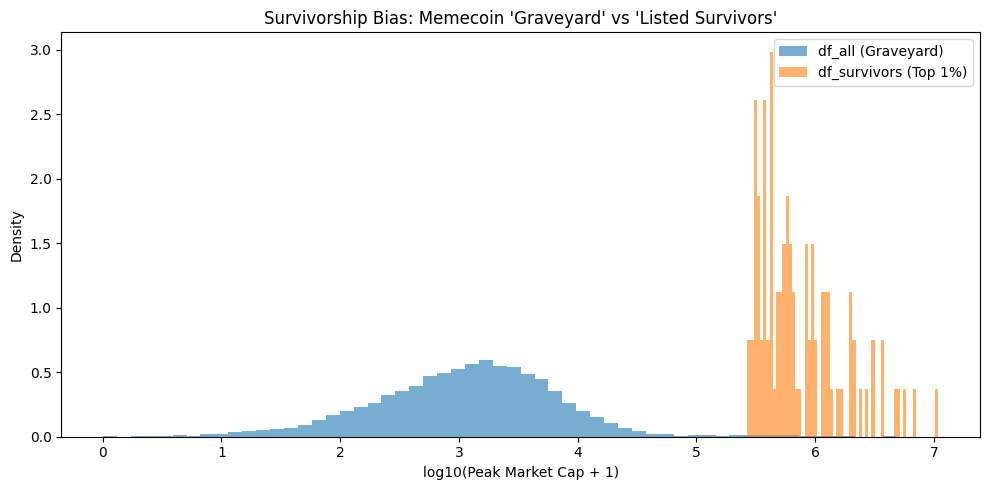

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Task 4.1: Memecoin Graveyard
# ----------------------------

np.random.seed(42)

N = 10_000

# Pareto / power-law-ish peaks:
# np.random.pareto(a) returns values near 0 with a long right tail.
# We'll scale it to something "market-cap-like".
alpha = 2.5                 # tail thickness (lower = fatter tail)
scale_mcap = 1_000_000      # $ scale for peak market cap

# Base Pareto draws (mostly near 0, few huge)
pareto_draws = np.random.pareto(alpha, size=N)

# Convert to "Peak Market Cap" (USD)
peak_mcap = pareto_draws * scale_mcap

# Add a big survivorship bias effect: 98.6% fail (near-zero-ish outcomes)
# We'll model "failed tokens" as getting their peak effectively crushed.
fail_rate = 0.986
is_failed = np.random.rand(N) < fail_rate

# Crush failed tokens near zero (but not exactly 0 to keep histogram sane)
# This is the "graveyard" that platforms often hide.
peak_mcap[is_failed] = peak_mcap[is_failed] * np.random.uniform(0.0001, 0.01, size=is_failed.sum())

# Build df_all (the graveyard)
df_all = pd.DataFrame({
    "token_id": np.arange(N),
    "peak_market_cap": peak_mcap,
    "failed": is_failed
})

# Survivors = top 1% by peak market cap (the "listed coins only" lie)
cutoff = df_all["peak_market_cap"].quantile(0.99)
df_survivors = df_all[df_all["peak_market_cap"] >= cutoff].copy()

# Means to expose the bias
mean_all = df_all["peak_market_cap"].mean()
mean_survivors = df_survivors["peak_market_cap"].mean()

print(f"Total tokens launched: {N}")
print(f"Fail rate simulated: {fail_rate*100:.1f}%")
print(f"Survivors kept (top 1%): {len(df_survivors)}")
print(f"Mean Peak Market Cap (ALL tokens):       ${mean_all:,.2f}")
print(f"Mean Peak Market Cap (SURVIVORS only):   ${mean_survivors:,.2f}")
print(f"Inflation factor from survivorship bias: {mean_survivors/mean_all:,.1f}x")

# ----------------------------
# Dual histogram visualization
# ----------------------------

# To make the plot readable, use log10 market cap (handles huge tail)
df_all["log10_peak_mcap"] = np.log10(df_all["peak_market_cap"] + 1)
df_survivors["log10_peak_mcap"] = np.log10(df_survivors["peak_market_cap"] + 1)

plt.figure(figsize=(10, 5))
plt.hist(df_all["log10_peak_mcap"], bins=60, alpha=0.6, label="df_all (Graveyard)", density=True)
plt.hist(df_survivors["log10_peak_mcap"], bins=60, alpha=0.6, label="df_survivors (Top 1%)", density=True)

plt.title("Survivorship Bias: Memecoin 'Graveyard' vs 'Listed Survivors'")
plt.xlabel("log10(Peak Market Cap + 1)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
